**k-seq data analysis tutorial**

This is the Jupyter Notebook implementation of `k-seq` package with its core functions, including:

- Parse and overview count files
- Extract detected sequences
- [For this tutorial] Filter sequence before fitting
- Fit each sequence into kinetic model

`k-seq` package [under development] provide core functions to parse, process, visualize and convert data from k-seq experiments. It is currently implemented as a `python` package for flexible and customized pipeline building. It will provide wrappers with standalone command line tools in future release.

# Environment setting

- Setup environmental variables `ENV`
- Add/reset the package directory (use package without `pip install k_seq`)
- Import core modules
  - `k_seq.data.pre_processing`: core module for data preprocessing before fitting
  - `k_seq.data.analysis`: module for preprocessing data analysis
  - `k_seq.fitting.fitting`: core module for kinetic model fitting
  - `k_seq.fitting.analysis`: module for fitting result analysis
  - `k_seq.utility`: module contains package-wide utility function
  - `util`: module contains global utility function

In [214]:
# Set up environmental variables: change the directory to your system
class EnvVar:
    HOME_DIR = 'home/yuning'
    PACKAGE_PATH = '/home/yuning/Work/k-seq/src'
    DATA_PATH= '/mnt/storage/projects/k-seq/input/bfo_counts/counts'
ENV = EnvVar()

# Add package directory for python kernel to import
import sys
if ENV.PACKAGE_PATH not in sys.path:
    sys.path = [ENV.PACKAGE_PATH] + sys.path

# import modules
import util
import importlib
import k_seq.data.pre_processing as pre_processing
import k_seq.data.analysis as analysis
import k_seq.fitting.fitting as fitting
import k_seq.fitting.analysis as fit_analysis
import k_seq.utility as utility
importlib.reload(pre_processing)# refresh data module
importlib.reload(analysis)# refresh data module
importlib.reload(fit_analysis)
importlib.reload(fitting)
importlib.reload(utility)

# Set up matplotlib dpi for visualization
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# Count file overview
Let's first look at the count files we will use for k-seq analysis

Jupyter Notebook can execute `shell` command within a `python` block using decorator '!'

E.g.

```Shell
!pwd
> current/direcotry/jupyter/notebook/kernel/starts
```

`python` variable's value can be called by `{variable}` in `shell` command

In [187]:
# show current kernel directory


/home/yuning/Work/k-seq/examples


In [188]:
# use shell command `ls` to list the file under ENV.DATA_PATH
!ls -lh {ENV.DATA_PATH}

total 153M
-rwxrwxr-x 1 yuning yuning 161K Dec 27 11:38 R4A-0A_S7_counts.txt
-rwxrwxr-x 1 yuning yuning 121K Dec 27 11:38 R4A-0B_S14_counts.txt
-rwxrwxr-x 1 yuning yuning 1.5M Dec 27 11:38 R4A-10A_S5_counts.txt
-rwxrwxr-x 1 yuning yuning 3.9M Dec 27 11:38 R4A-10B_S12_counts.txt
-rwxrwxr-x 1 yuning yuning 1.7M Dec 27 11:38 R4A-1250A_S2_counts.txt
-rwxrwxr-x 1 yuning yuning 2.9M Dec 27 11:38 R4A-1250B_S9_counts.txt
-rwxrwxr-x 1 yuning yuning 1.3M Dec 27 11:38 R4A-250A_S3_counts.txt
-rwxrwxr-x 1 yuning yuning 7.3M Dec 27 11:38 R4A-250B_S10_counts.txt
-rwxrwxr-x 1 yuning yuning 1.9M Dec 27 11:38 R4A-2A_S6_counts.txt
-rwxrwxr-x 1 yuning yuning 2.3M Dec 27 11:38 R4A-2B_S13_counts.txt
-rwxrwxr-x 1 yuning yuning 2.7M Dec 27 11:38 R4A-50A_S4_counts.txt
-rwxrwxr-x 1 yuning yuning 3.6M Dec 27 11:38 R4A-50B_S11_counts.txt
-rwxrwxr-x 1 yuning yuning  25M Dec 27 11:38 R4A-inputA_S1_counts.txt
-rwxrwxr-x 1 yuning yuning 9.0M Dec 27 11:38 R4A-inputB_S8_counts.txt
-rwxrwxr-x 1 yuning yuning 114K Dec 27

In [189]:
# use shell command `wc` to get the number of lines of R4A-inputA_S1_counts.txt
print(util.color.BOLD + util.color.BLUE + \
'Number of lines in file:' + util.color.END)

!wc -l {ENV.DATA_PATH + '/R4A-inputA_S1_counts.txt'}

# use shell command `head` to check the top 20 lines of R4A-inputA_S1_counts.txt
print(util.color.BOLD + util.color.BLUE + \
'Top 20 lines of file:' + util.color.END)

!head -n 20 {ENV.DATA_PATH + '/R4A-inputA_S1_counts.txt'}

Number of lines in file:
330568 /mnt/storage/projects/k-seq/input/bfo_counts/counts/R4A-inputA_S1_counts.txt
Top 20 lines of file:
number of unique sequences = 330565
total number of molecules = 2165970

CTACTTCAAACAATCGGTCTG                                                      605843
AAAAACAAAAACAAAAACAAA                                                      395313
ATTACCCTGGTCATCGAGTGA                                                      187328
ATTACCCTGGTCATCGAGTGT                                                      122377
ATTCACCTAGGTCATCGGGTG                                                      88556
CTCTTCAAACAATCGGTCTTC                                                      84124
ATTCACCTAGGTCATCGGGTGT                                                     63570
CCACACTTCAAGCAATCGGTC                                                      46155
CCGCTTCAAACAATCGGTTTG                                                      28860
ATTCACCTAGGTCATCGAGTGT                                         

# Parse count files
## Use `pre_processing.SequencingSample` to parse single count file
Try to load in a single count file `R4A-1250A_S2_counts.txt`

In [190]:
?pre_processing.SequencingSample()

In [203]:
# Given file name R4A-1250A_S2_counts.txt, it follows pattern
#          [R4{exp_rep}-{byo, float}{seq_rep}_S{id,int}]_counts.txt

single_sample = pre_processing.SequencingSample(
    file_dirc= ENV.DATA_PATH + '/R4A-1250A_S2_counts.txt',
    name_pattern='[R4{exp_rep}-{byo, float}{seq_rep}_S{id,int}]_counts.txt',
    silent=False,
    x_value='byo'
)

Sample R4A-1250A_S2 imported from /mnt/storage/projects/k-seq/input/bfo_counts/counts/R4A-1250A_S2_counts.txt


**What contains in the a `SequencingSample` object?**

In [ ]:
# Use autocompletion and `?` to explore the function of `SequencingSample` object


**Use `survey_spike_in` to calculate the distribution of spike-in sequence in surrounding sequence space**

In [24]:
results = single_sample.survey_spike_in(
    spike_in='AAAAACAAAAACAAAAACAAA',
    max_dist_to_survey=10,
    silent=False,
    inplace=False
)

Survey spike-in counts for sample R4A-1250A_S2. Done.


**Use `matplotlib.pyplot` to visualize the local distribution of spike-in peak**

In [192]:
# Visualize the peak of spike-in
import matplotlib.pyplot as plt

# Visualization code:




## Use `pre_processing.SequencingSampleSet` to parse a batch (folder) of count files 
### Parse count files from `~/data/count/`

In [204]:
sample_set = pre_processing.SequencingSampleSet(
    file_root=ENV.DATA_PATH,
    pattern='_counts.txt',
    x_values='byo',
    name_pattern='[R4{select_rep}-{byo, float}{sequence_rep}_S{sample_id, int}]_counts.txt',
    sort_fn = lambda sample: sample.metadata['sample_id']
)

### explore the imported sample

In [193]:
?sample_set

**Use `analysis.sequencing_sample_info_table` to print out an overview table**

In [65]:
analysis.sequencing_sample_info_table(sample_set=filtered_sample_set, return_table=False)

,sample type,name,total counts,unique sequences,x_value
0,input,R4A-inputA_S1,"2,165,970","330,565",NaN
1,reacted,R4A-1250A_S2,"2,006,578","29,455",1250
2,reacted,R4A-250A_S3,"1,845,900","23,911",250
3,reacted,R4A-50A_S4,"2,617,260","43,687",50
4,reacted,R4A-10A_S5,"1,515,552","26,410",10
5,reacted,R4A-2A_S6,"1,580,503","24,362",2
6,input,R4A-inputB_S8,"1,257,100","174,225",NaN
7,reacted,R4A-1250B_S9,"3,451,114","42,691",1250
8,reacted,R4A-250B_S10,"10,273,787","120,423",250
9,reacted,R4A-50B_S11,"2,544,354","56,718",50


**Use `analysis.sequencing_sample_info_plot` to plot an overview figure for samples**

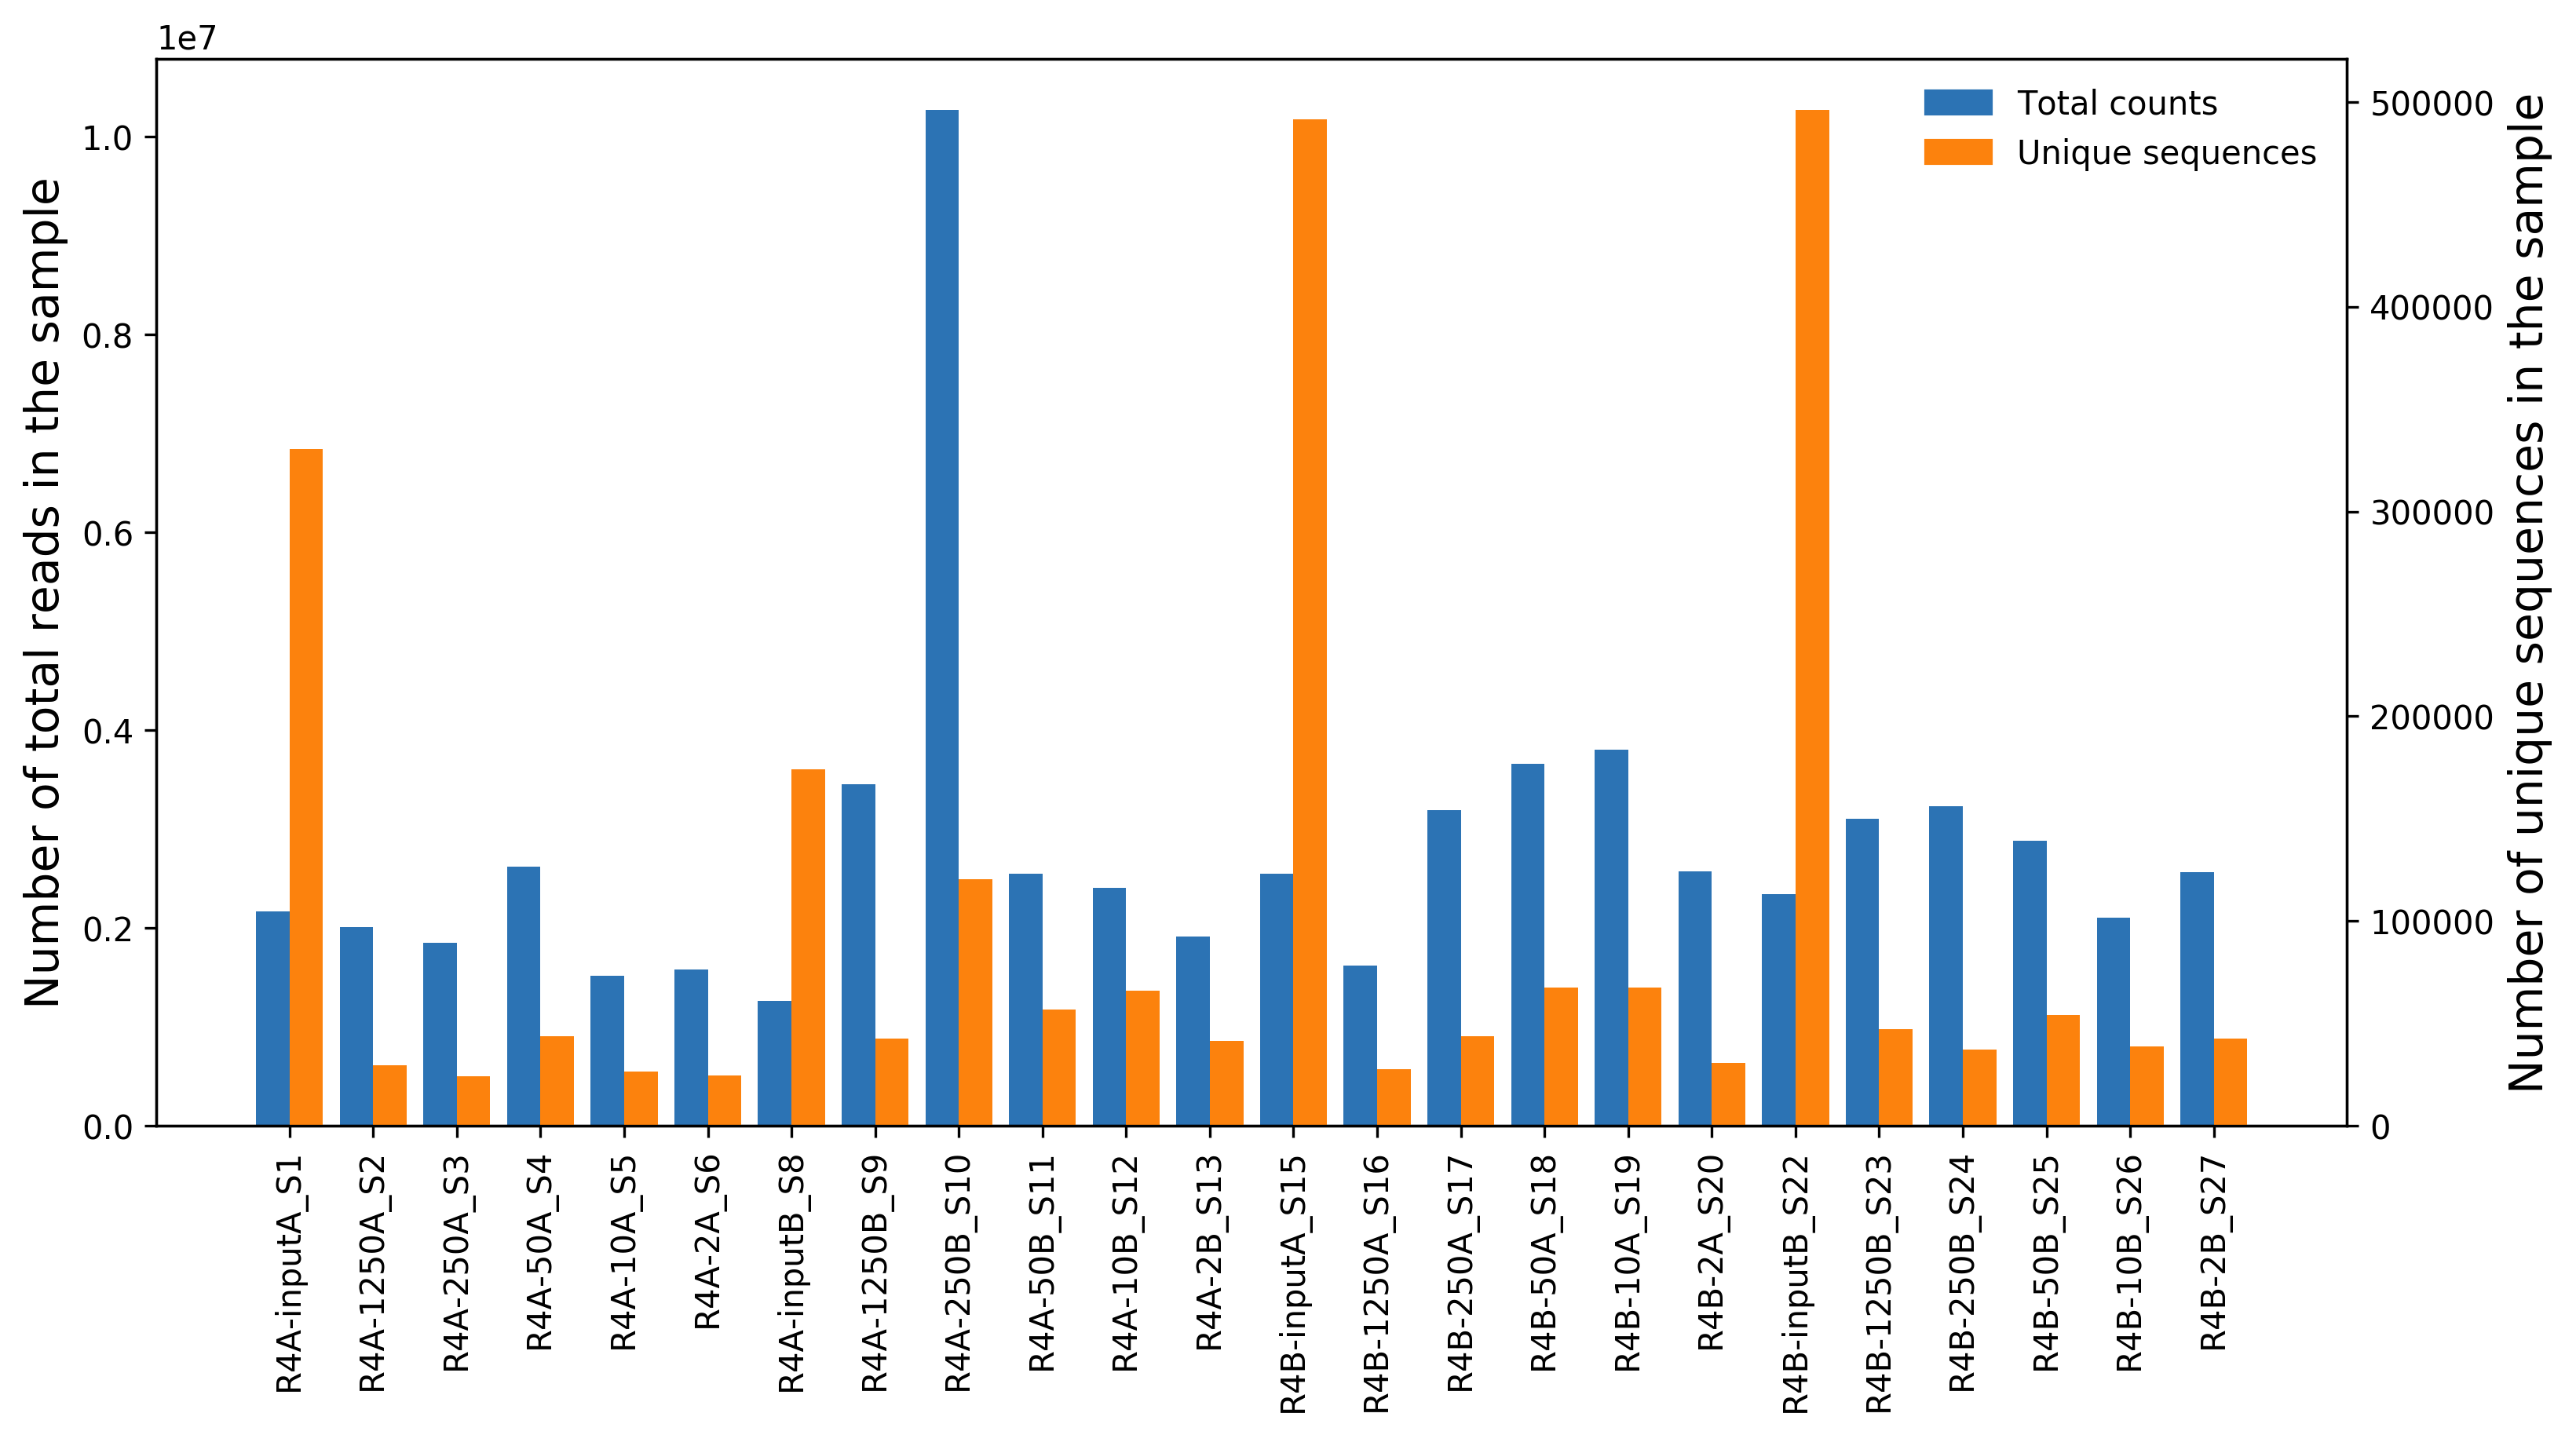

In [78]:
analysis.sequencing_sample_info_plot(sample_set=filtered_sample_set)

### Calculate quantification factor for each sample using spike in

$$
\text{Seq amount} = \frac{\text{Seq count}}{\text{spike-in count}}\times \text{spike-in amount} = \frac{\text{Seq count}}{\text{Total count}}\times \Large (\frac{\text{Total count}}{\text{spike-in count}}\times\text{spike-in amount}\Large )
$$

In [98]:
# indicate spike-in amount to calculate quantification factors
spike_in_amounts = []
for i in range(4):
    spike_in_amounts += [4130, 1240, 826, 413, 207, 82.6, 41.3]

sample_set.get_quant_factors(
    max_dist=2,
    max_dist_to_survey=10,
    spike_in='AAAAACAAAAACAAAAACAAA',
    spike_in_amounts=spike_in_amounts,
    silent=False
)

Survey spike-in counts for sample R4A-inputA_S1. Done.
Survey spike-in counts for sample R4A-1250A_S2. Done.
Survey spike-in counts for sample R4A-250A_S3. Done.
Survey spike-in counts for sample R4A-50A_S4. Done.
Survey spike-in counts for sample R4A-10A_S5. Done.
Survey spike-in counts for sample R4A-2A_S6. Done.
Survey spike-in counts for sample R4A-0A_S7. Done.
Survey spike-in counts for sample R4A-inputB_S8. Done.
Survey spike-in counts for sample R4A-1250B_S9. Done.
Survey spike-in counts for sample R4A-250B_S10. Done.
Survey spike-in counts for sample R4A-50B_S11. Done.
Survey spike-in counts for sample R4A-10B_S12. Done.
Survey spike-in counts for sample R4A-2B_S13. Done.
Survey spike-in counts for sample R4A-0B_S14. Done.
Survey spike-in counts for sample R4B-inputA_S15. Done.
Survey spike-in counts for sample R4B-1250A_S16. Done.
Survey spike-in counts for sample R4B-250A_S17. Done.
Survey spike-in counts for sample R4B-50A_S18. Done.
Survey spike-in counts for sample R4B-10A

In [99]:
sample_set.sample_set[0].spike_in

{'quant_factor_max_dist': 2,
 'spike_in_amount': 4130,
 'spike_in_counts': array([395313,  18939,   2186,    751,    359,    140,    187,     32,
            19,     55,    244]),
 'spike_in_seq': 'AAAAACAAAAACAAAAACAAA'}

**Let's look at the overview again using `analysis.sequencing_sample_info_table/plot`**

,sample type,name,total counts,unique sequences,x_value,spike-in amount,spike-in counts (dist=2),spike-in percent,quantification factor
0,input,R4A-inputA_S1,"2,165,970","330,565",NaN,4130.0,416438,0.192,2.148e+04
1,reacted,R4A-1250A_S2,"2,006,578","29,455",1250,1240.0,322730,0.161,7.710e+03
2,reacted,R4A-250A_S3,"1,845,900","23,911",250,826.0,267257,0.145,5.705e+03
3,reacted,R4A-50A_S4,"2,617,260","43,687",50,413.0,453121,0.173,2.386e+03
4,reacted,R4A-10A_S5,"1,515,552","26,410",10,207.0,351337,0.232,8.929e+02
5,reacted,R4A-2A_S6,"1,580,503","24,362",2,82.6,460933,0.292,2.832e+02
6,reacted,R4A-0A_S7,"2,948,173","2,825",0,41.3,2839946,0.963,4.287e+01
7,input,R4A-inputB_S8,"1,257,100","174,225",NaN,4130.0,304332,0.242,1.706e+04
8,reacted,R4A-1250B_S9,"3,451,114","42,691",1250,1240.0,601219,0.174,7.118e+03
9,reacted,R4A-250B_S10,"10,273,787","120,423",250,826.0,1312643,0.128,6.465e+03


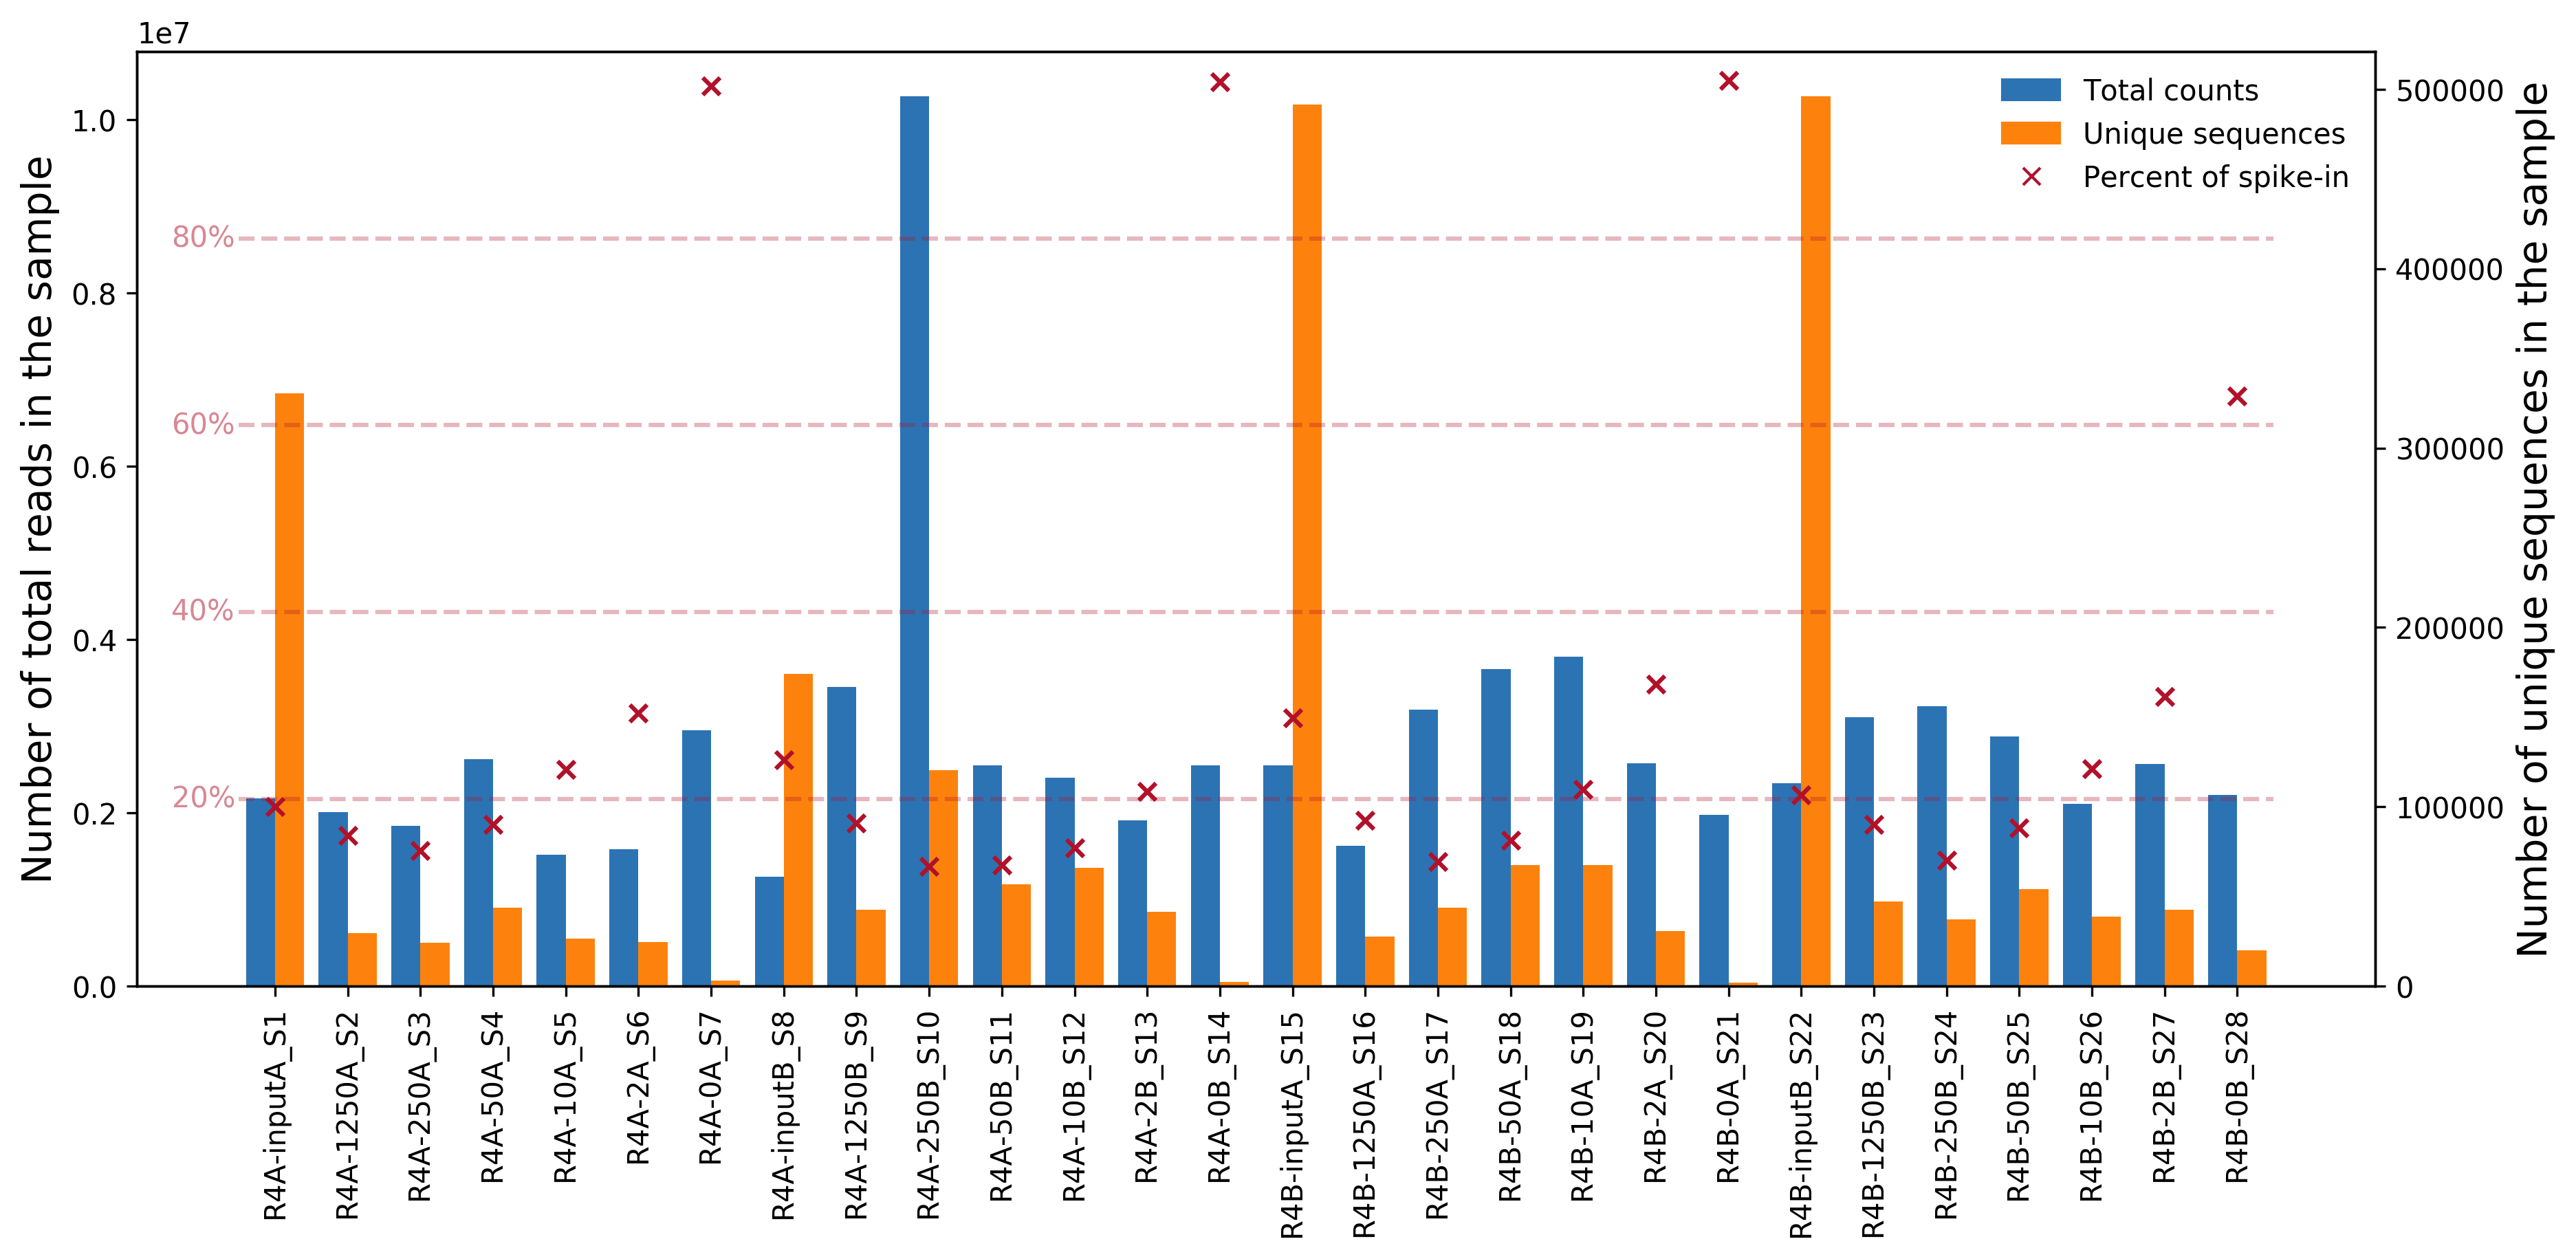

In [104]:
analysis.sequencing_sample_info_table(sample_set)
analysis.sequencing_sample_info_plot(sample_set)

### Filter sample
As an optional, we can discard 0 concentraton samples as very limited sequencees from these samples

In [207]:
?sample_set.filter_sample

In [ ]:
zero_sample_list = [sample.name for sample in sample_set.sample_set if sample.metadata['byo'] == 0]
print(zero_sample_list)
## How to get samples that are not 0?

In [105]:
filtered_sample_set = sample_set.filter_sample(sample_to_keep=[sample.name for sample in sample_set.sample_set 
                                                               if sample.metadata['byo'] != 0],
                                               inplace=False)

In [ ]:
analysis.sequencing_sample_info_table(filtered_sample_set)
analysis.sequencing_sample_info_plot(filtered_sample_set)

# Extract valid sequences
## `SequencingSampleSet` $\to$ `SequenceSet`

In [177]:
sequence_set = pre_processing.SequenceSet(sample_set=filtered_sample_set, remove_spike_in=True, note='test')

In [213]:
?sequence_set

In [ ]:
sequence_set.dataset_info

In [ ]:
sequence_set.count_table

## How do these sequences distribute across samples

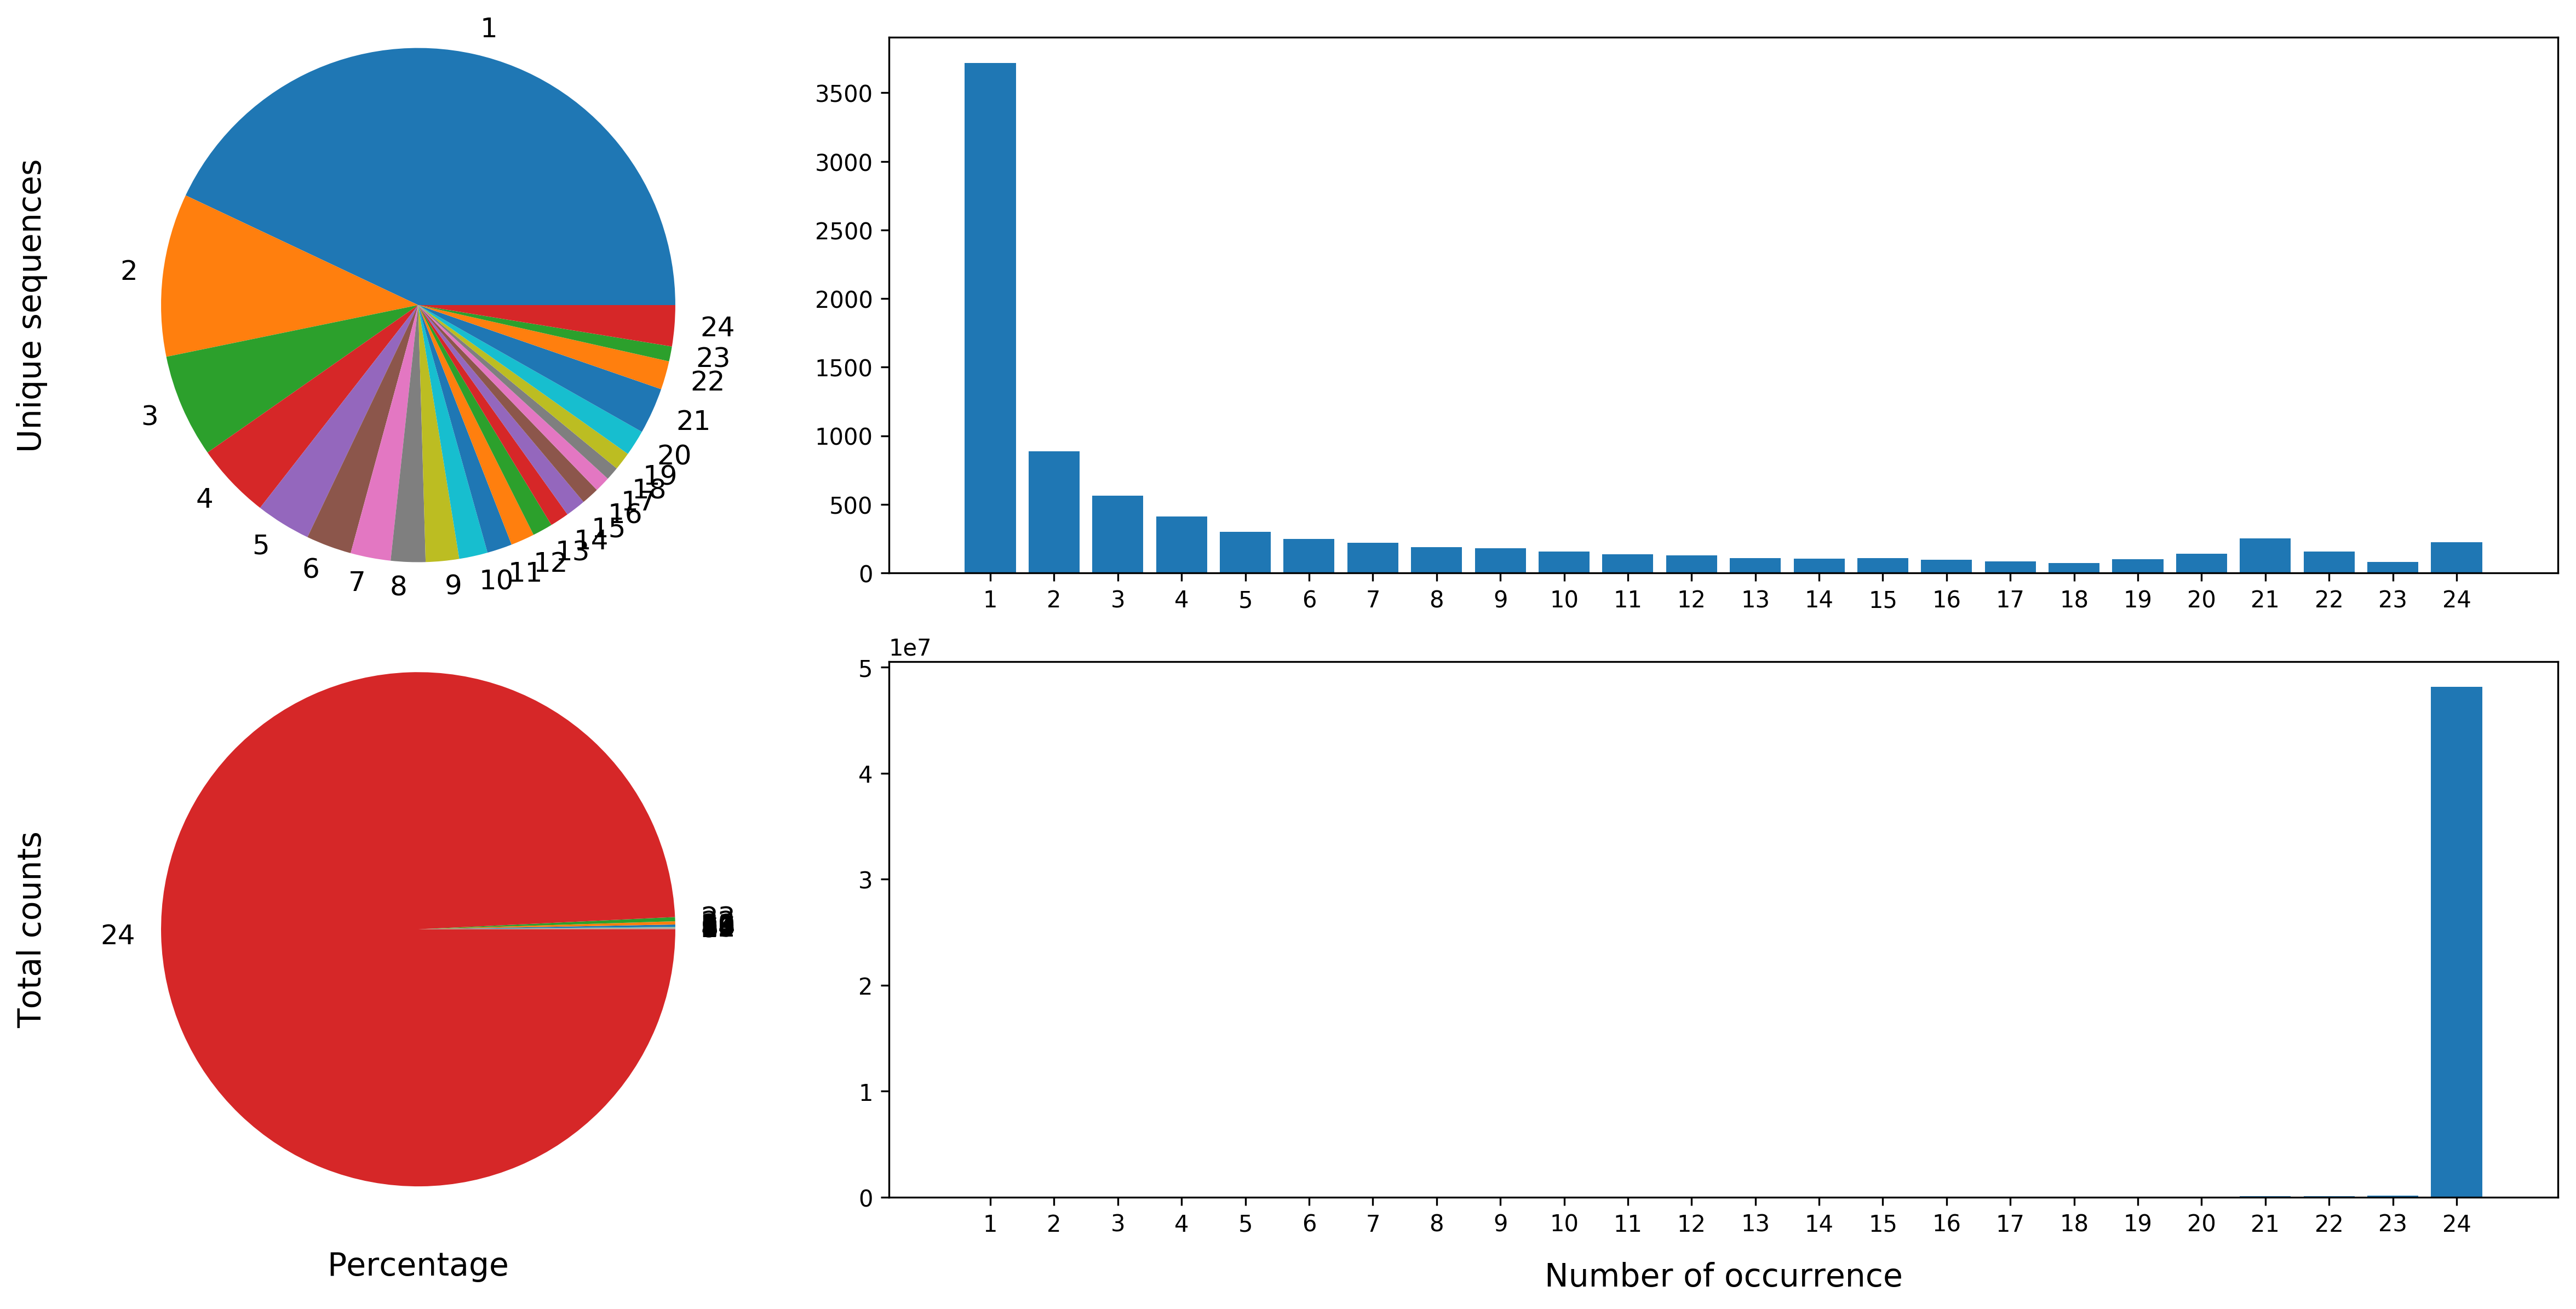

In [158]:
sequence_set = analysis.survey_seqs_info(sequence_set)
count_bins, count_bins_weighted = analysis.survey_seq_occurrence(sequence_set=sequence_set, display=True)

## Normalize counts into reacted fraction

In [215]:
zero_samples = [sample_name for sample_name in sequence_set.sample_info.keys() if '-0' in sample_name]
sequence_set.get_reacted_frac(
    input_average='median',
    black_list=zero_samples,
    inplace=True
)

## [Optional] Filter sequences

In [216]:
?sequence_set.filter_seq

In [186]:
util.dump_pickle(fitting_new,dirc='/mnt/storage/projects/k-seq/output/sequence_set_test.pkl',log='test sequenceset',overwrite=True)

Data has been saved to /mnt/storage/projects/k-seq/output/sequence_set_test.pkl


# Fitting w/ uncertainty estimation
## Fit single function

## Valid sequence characterization

In [182]:
fitting.fitting_sequence_set(fitting_new, inplace=True)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:24: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [180]:
seq_to_keep = list(sequence_set.reacted_frac_table[:10].index)
fitting_new = sequence_set.filter_seq(seq_to_keep=seq_to_keep, inplace=False)

In [181]:
fitting_new.reacted_frac_table.col_x_values

[1250.0,
 250.0,
 50.0,
 10.0,
 2.0,
 1250.0,
 250.0,
 50.0,
 10.0,
 2.0,
 1250.0,
 250.0,
 50.0,
 10.0,
 2.0,
 1250.0,
 250.0,
 50.0,
 10.0,
 2.0]

In [45]:
fitting_res = fitting.fitting_single(x_data=x_data,
                           y_data=y_data,
                           func=curve,
                           missing_data_as_zero=False,
                           bootstrap=True,
                           bounds=((0, 0, -np.inf), (1, np.inf, np.inf)),
                           bs_depth=2000,
                           bs_residue=True,
                           bs_return_verbose=True)

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [541]:
fitting.fitting_sequence_set(sequence_set=sequence_set_test, inplace=True, parallel_threads=6)

/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq/src/k_seq/fitting/fitting.py:23: RuntimeWarning: overflow encountered in exp
  return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BYO degradation adjustment and 90 minutes
/home/yuning/Work/k-seq

In [208]:
import matplotlib.pyplot as plt


x_values = np.linspace(0, 1000, 500)
y_values = curve(x_values, 0.001307, 20.48, 0.0002)
plt.scatter(fitting_res[0]['x_data'], fitting_res[0]['y_data'], marker='*')
plt.plot(x_values, y_values, '--')
plt.ylim([0, 0.002])
plt.show()


NameError: name 'np' is not defined

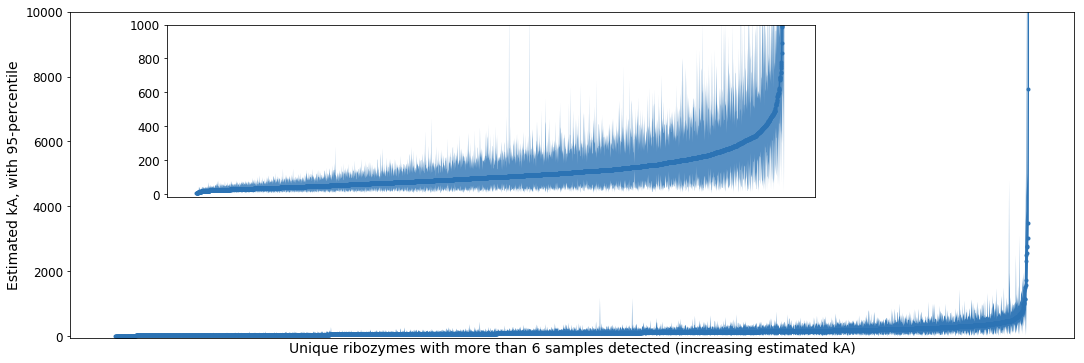

In [183]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 10000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_ylim([-20, 1000])
    axInset.set_xticks([])
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

surveyRes = []
# Only survey ribozymes at least detected 6 times and the CI can be estimated, return prediction and CI
for res in fittingRes:
    if np.sum(~np.isnan(res['kSeqFmol'])) >= 6 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(filter_fn(res))
sort_fn = lambda a: (a[0])
surveyRes.sort(key=sort_fn)

value_plot(surveyRes)